Multi-level Texture Synthesisは速度や精度の面でそれなりに良い結果を出すことができるので、いくつか試すことにする。

In [10]:
from datetime import datetime

import cv2
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from PIL import Image

def multi_level_synthesis(path_to_texture_img, target_width=128, adding_noise=False):
    texture = cv2.imread(path_to_texture_img)
    texture = cv2.cvtColor(texture, cv2.COLOR_BGR2RGB)
    print("texture image size is", texture.shape)

    target = np.random.randint(0, 256, size=(target_width, target_width, 3), dtype=np.uint8)
    img_display = display(Image.fromarray(target), display_id=True)

    ### item for algorithm
    current_texture = cv2.resize(texture, (texture.shape[0] // 4, texture.shape[1] // 4))
    current_target = cv2.resize(target, (target_width // 4, target_width // 4))
    neighbor_width = 8


    def init_anchors(target_width, neighbor_width, current_texture):
        indices = np.arange(0, target_width - neighbor_width + 1, neighbor_width // 4)
        x, y = np.meshgrid(indices, indices)
        target_anchors = np.column_stack((y.ravel(), x.ravel()))

        texture_anchors = np.zeros((len(target_anchors), 2), dtype=int)
        texture_anchors[:, 0] = np.random.randint(
            0, current_texture.shape[0] - neighbor_width, size=len(target_anchors)
        )
        texture_anchors[:, 1] = np.random.randint(
            0, current_texture.shape[1] - neighbor_width, size=len(target_anchors)
        )
        return target_anchors, texture_anchors

    target_anchors, texture_anchors = init_anchors(
        current_target.shape[0], neighbor_width, current_texture
    )

    def update_anchors(target_width, neighbor_width, current_texture):
        indices = np.arange(0, target_width - neighbor_width + 1, neighbor_width // 4)
        x, y = np.meshgrid(indices, indices)
        target_anchors = np.column_stack((y.ravel(), x.ravel()))

        texture_anchors = np.zeros((len(target_anchors), 2), dtype=int)
        for i, target_anchor in enumerate(target_anchors):
            y, x = target_anchor
            result = cv2.matchTemplate(
                current_texture,
                current_target[y : y + neighbor_width, x : x + neighbor_width, :],
                method=cv2.TM_SQDIFF,
            )
            _, _, min_loc, _ = cv2.minMaxLoc(result)
            texture_anchors[i] = np.array([min_loc[1], min_loc[0]])

        return target_anchors, texture_anchors

    loss_history = []
    phase = 0
    is_transiting = False

    iter = 1
    while iter < 100:
        iter += 1

        ### scheduling for neighbor_width and resolution
        if phase == 1 and is_transiting:
            transiting = False
            current_texture = cv2.resize(
                texture, (texture.shape[0] // 2, texture.shape[1] // 2)
            )
            current_target = cv2.resize(current_target, (target_width // 2, target_width // 2))
            neighbor_width = 16
            target_anchors, texture_anchors = update_anchors(
                current_target.shape[0], neighbor_width, current_texture
            )
        if phase == 2 and is_transiting:
            neighbor_width = 8
            target_anchors, texture_anchors = update_anchors(
                current_target.shape[0], neighbor_width, current_texture
            )
        if phase == 3 and is_transiting:
            current_texture = texture
            current_target = cv2.resize(current_target, (target_width, target_width))
            neighbor_width = 32
            target_anchors, texture_anchors = update_anchors(
                current_target.shape[0], neighbor_width, current_texture
            )
        if phase == 4 and is_transiting:
            neighbor_width = 16
            target_anchors, texture_anchors = update_anchors(
                current_target.shape[0], neighbor_width, current_texture
            )
        if phase == 5 and is_transiting:
            neighbor_width = 8
            target_anchors, texture_anchors = update_anchors(
                current_target.shape[0], neighbor_width, current_texture
            )
        if phase == 6:
            break

        # update target to argmin(E(target, texture))
        ref_for_pixel = [
            [] for _ in range(current_target.shape[0] * current_target.shape[1])
        ]

        for target_anchor, texture_anchor in zip(target_anchors, texture_anchors):
            y, x = target_anchor
            yy, xx = texture_anchor
            for i in range(neighbor_width):
                for j in range(neighbor_width):
                    ref_for_pixel[(y + i) * current_target.shape[1] + (x + j)].append(
                        current_texture[yy + i, xx + j]
                    )

        loss = 0
        for y in range(current_target.shape[0]):
            for x in range(current_target.shape[1]):
                current_target[y, x] = np.mean(
                    ref_for_pixel[y * current_target.shape[1] + x], axis=0
                )
                loss += np.sum(
                    (ref_for_pixel[y * current_target.shape[1] + x] - current_target[y, x]) ** 2
                )

        mse = loss / (current_target.shape[0] * current_target.shape[1]) / 3
        print(f"iter {iter}: loss:{mse}")
        loss_history.append(mse)
        img_display.update(
            Image.fromarray(current_target)
        )

        # update texture reference points
        texture_anchors_prev = texture_anchors.copy()
        target_anchors, texture_anchors = update_anchors(
            current_target.shape[0], neighbor_width, current_texture
        )

        if np.all(texture_anchors == texture_anchors_prev) or mse in loss_history[-3:-1]:
            phase += 1
            is_transiting = True
            print(f"transiting!!! phase {phase}")

        # add noise here
        if adding_noise and iter < 50:
            noise = np.random.randint(0, 256, size=current_target.shape, dtype=np.uint8)
            current_target = cv2.addWeighted(current_target, iter / 50, noise, 1 - (iter / 50), 0)
            img_display.update(Image.fromarray(current_target))

    plt.plot(range(1, len(loss_history) + 1), loss_history, "ro-")
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.title("loss history")
    plt.show()

    target[:, :, :] = current_target
    display(Image.fromarray(target))

    now = datetime.now()
    now = now.strftime("%Y%m%d%H%M%S")
    Image.fromarray(target).save(f"synthesized_mul_texture_{now}.png")

texture image size is (64, 64, 3)


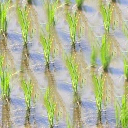

iter 2: loss:988.9401041666666
iter 3: loss:942.0380859375
iter 4: loss:919.908203125
iter 5: loss:908.7939453125
iter 6: loss:908.1497395833334
iter 7: loss:912.1953125
iter 8: loss:909.8349609375
iter 9: loss:905.587890625
iter 10: loss:897.3466796875
iter 11: loss:897.6761067708334
iter 12: loss:894.2923177083334
transiting!!! phase 1
iter 13: loss:872.5006510416666
iter 14: loss:858.6861979166666
iter 15: loss:851.2245279947916
iter 16: loss:839.7972819010416
iter 17: loss:836.3977864583334
iter 18: loss:836.990234375
iter 19: loss:835.7454427083334
iter 20: loss:835.1527506510416
iter 21: loss:835.188232421875
transiting!!! phase 2
iter 22: loss:702.1411946614584
iter 23: loss:657.8125
iter 24: loss:639.5481770833334
iter 25: loss:633.2569173177084
iter 26: loss:628.692138671875
iter 27: loss:624.7337239583334
iter 28: loss:621.1856282552084
iter 29: loss:621.571533203125
iter 30: loss:620.8123372395834
iter 31: loss:620.6072591145834
transiting!!! phase 3
iter 32: loss:894.334737

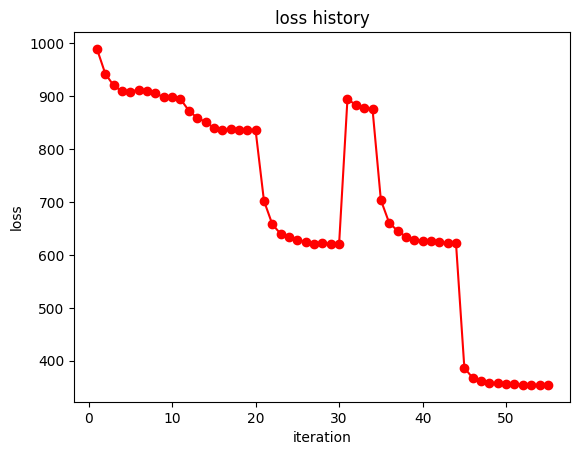

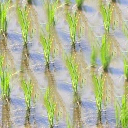

In [4]:
multi_level_synthesis("sample_images/ine_64.jpg")

texture image size is (64, 64, 3)


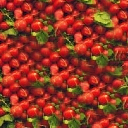

iter 2: loss:1039.3854166666667
iter 3: loss:985.47265625
iter 4: loss:971.6813151041666
iter 5: loss:968.1015625
iter 6: loss:938.4547526041666
iter 7: loss:936.0738932291666
iter 8: loss:918.2102864583334
iter 9: loss:900.4391276041666
iter 10: loss:903.0423177083334
iter 11: loss:901.1194661458334
iter 12: loss:893.0208333333334
transiting!!! phase 1
iter 13: loss:877.0327962239584
iter 14: loss:863.8863932291666
iter 15: loss:854.3831380208334
iter 16: loss:846.38916015625
iter 17: loss:829.2191569010416
iter 18: loss:821.303955078125
transiting!!! phase 2
iter 19: loss:657.66845703125
iter 20: loss:599.4100748697916
iter 21: loss:584.5054524739584
iter 22: loss:578.6097819010416
iter 23: loss:575.0520833333334
iter 24: loss:572.3855794270834
iter 25: loss:572.175537109375
iter 26: loss:572.159912109375
iter 27: loss:573.0453287760416
iter 28: loss:572.1348470052084
transiting!!! phase 3
iter 29: loss:870.0883992513021
iter 30: loss:854.6913859049479
iter 31: loss:849.3233642578125

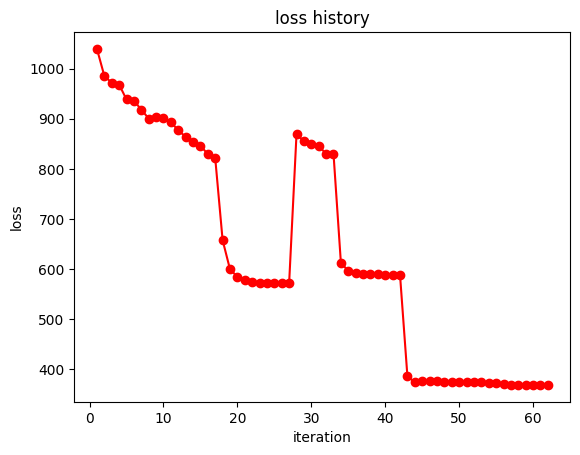

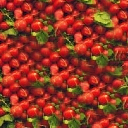

In [5]:
multi_level_synthesis("sample_images/kudamono_64.jpg")

texture image size is (64, 64, 3)


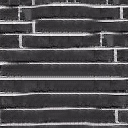

iter 2: loss:1144.5380859375
iter 3: loss:1009.203125
iter 4: loss:976.94140625
iter 5: loss:961.8082682291666
iter 6: loss:924.8121744791666
iter 7: loss:878.0201822916666
iter 8: loss:865.4970703125
iter 9: loss:835.4475911458334
iter 10: loss:823.8046875
iter 11: loss:820.6845703125
iter 12: loss:820.1432291666666
transiting!!! phase 1
iter 13: loss:862.2957356770834
iter 14: loss:837.38720703125
iter 15: loss:827.06005859375
iter 16: loss:822.2361653645834
iter 17: loss:815.5891927083334
iter 18: loss:810.3435872395834
iter 19: loss:803.2765299479166
iter 20: loss:790.7854817708334
iter 21: loss:784.8439127604166
iter 22: loss:785.289306640625
iter 23: loss:782.659423828125
iter 24: loss:781.3892415364584
transiting!!! phase 2
iter 25: loss:701.6665852864584
iter 26: loss:646.3915201822916
iter 27: loss:617.4297688802084
iter 28: loss:609.3435872395834
iter 29: loss:603.1641438802084
iter 30: loss:600.83642578125
iter 31: loss:598.0536295572916
iter 32: loss:598.1939290364584
iter 

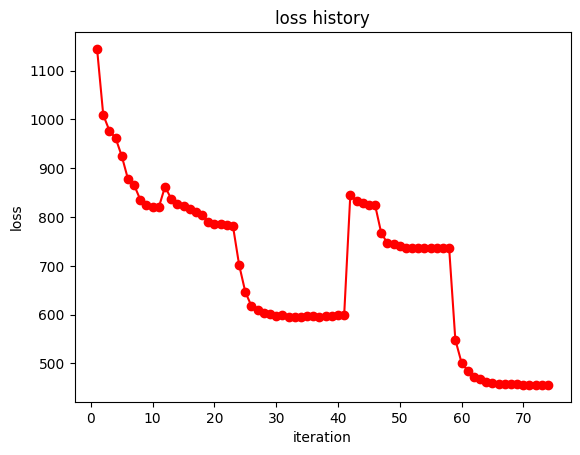

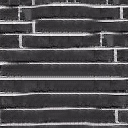

In [6]:
multi_level_synthesis("sample_images/renga_64.jpg")

texture image size is (64, 64, 3)


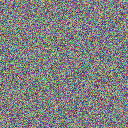

iter 2: loss:1153.5651041666667
iter 3: loss:1001.1640625
iter 4: loss:942.2477213541666
iter 5: loss:879.8232421875
iter 6: loss:860.2770182291666
iter 7: loss:824.50390625
iter 8: loss:793.2122395833334
iter 9: loss:786.6526692708334
iter 10: loss:794.1416015625
iter 11: loss:790.55859375
iter 12: loss:788.9817708333334
iter 13: loss:787.5849609375
iter 14: loss:788.8030598958334
iter 15: loss:791.046875
iter 16: loss:790.1178385416666
iter 17: loss:790.8759765625
iter 18: loss:793.6087239583334
iter 19: loss:788.4827473958334
transiting!!! phase 1


KeyboardInterrupt: 

In [11]:
multi_level_synthesis("sample_images/renga_64.jpg", adding_noise=True)